In [1]:
import gym
import random
import numpy as np
from collections import deque

import torch

from IPython import display
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from per_agent import PERAgent
from model import QNetwork

In [2]:
env = gym.make('MountainCar-v0')
o_dim = env.observation_space.shape[0]
a_dim = env.action_space.n
print('State shape: ', o_dim)
print('Number of actions: ', a_dim)

State shape:  2
Number of actions:  3


In [30]:
d = env.observation_space.high - env.observation_space.low
def rescale(state):
    return (state - env.observation_space.low)/d

In [32]:
rescale(next_state)

array([0.27074777, 0.40427619])

## poritized experience replay

In [51]:
LR = 5e-4               # learning rate
LR_STEP_SIZE = 7
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
BUFFER_SIZE = int(1e6)  # replay buffer size
UPDATE_EVERY = 1        
SEED = 1234

In [52]:
# parameters for training
NUM_EPISODES = 1500
PRINT_EVERY = 100
TMAX = 200

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

In [53]:
agent = PERAgent(QNetwork, o_dim, a_dim, lr = LR, lr_step_size = LR_STEP_SIZE, 
              batch_size = BATCH_SIZE, gamma = GAMMA, tau = TAU, buffer_size = BUFFER_SIZE,
              update_every = UPDATE_EVERY, seed = SEED, algorithm = "ddqn")
print(agent.algorithm)
agent.target_net

ddqn


QNetwork(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [54]:
score_list = []
score_window = deque(maxlen = PRINT_EVERY)  

eps = eps_start
for e in range(1, NUM_EPISODES+1):
    
    state = rescale(env.reset())
    score = 0
    for t in range(TMAX):
        action = agent.get_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        next_state = rescale(next_state)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\r\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        agent.scheduler.step()
        

Episode 100	sum of rewards  -200.00
Episode 200	sum of rewards  -200.00
Episode 300	sum of rewards  -193.26
Episode 400	sum of rewards  -172.64
Episode 500	sum of rewards  -172.42
Episode 600	sum of rewards  -173.59
Episode 700	sum of rewards  -151.49
Episode 800	sum of rewards  -136.76
Episode 900	sum of rewards  -134.20
Episode 1000	sum of rewards  -129.32
Episode 1100	sum of rewards  -131.40
Episode 1200	sum of rewards  -133.38
Episode 1300	sum of rewards  -134.62
Episode 1400	sum of rewards  -131.84
Episode 1500	sum of rewards  -128.32


In [55]:
torch.save(agent.online_net.state_dict(), 'MountainCar.pth')

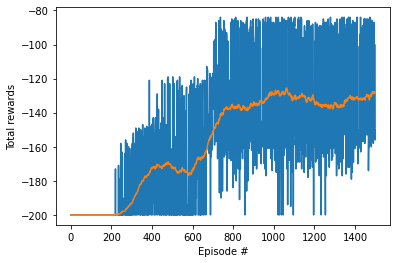

In [56]:
score1 = np.asarray(score_list).T
fig = plt.figure()
plt.plot(np.arange(score1.shape[1]), score1[0])
plt.plot(np.arange(score1.shape[1]), score1[1])
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.show()

In [43]:
from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [61]:
env = wrap_env( gym.make('MountainCar-v0'))

state = rescale(env.reset())
while True:
    action = agent.get_action(state, eps)
    next_state, reward, done, _ = env.step(action)
    next_state = rescale(next_state)
    state = next_state
    if done:
        break


env.close()